In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 24

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/22 [>.............................] - ETA: 7s - loss: 2.3993 - accuracy: 0.1094
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 1s 8ms/step - loss: 2.3038 - accuracy: 0.1432 - val_loss: 2.2438 - val_accuracy: 0.2184
Epoch 2/1000
 1/22 [>.............................] - ETA: 0s - loss: 2.2794 - accuracy: 0.1797
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 3ms/step - loss: 2.2468 - accuracy: 0.1725 - val_loss: 2.1956 - val_accuracy: 0.2250
Epoch 3/1000
 1/22 [>.............................] - ETA: 0s - loss: 2.2418 - accuracy: 0.1953
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
22/22 [==============================] - 0s 3ms/step - loss: 2.2124 - accuracy: 0.1798 - val_loss: 2.1366 - val_accuracy: 0.2349
Epoch 4/1000
 1/22 [>.............................] - ETA: 0s - loss: 2.1384 - accuracy: 0.1875
E

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 1ms/step - loss: 0.5503 - accuracy: 0.8705


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 44ms/step
[3.9926007e-02 3.6689442e-01 4.7570109e-02 2.6131846e-02 1.5833564e-01
 3.6057761e-01 1.3647888e-11 8.0301838e-08 9.4555064e-05 4.6964202e-04]
1


# Confusion matrix

29/29 [==============================] - 0s 1ms/step


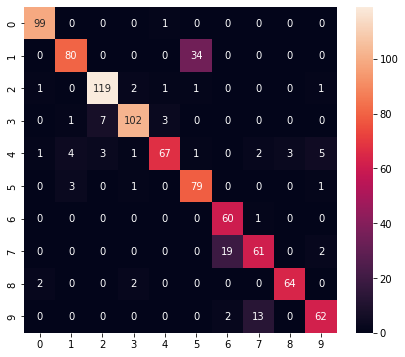

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       100
           1       0.91      0.70      0.79       114
           2       0.92      0.95      0.94       125
           3       0.94      0.90      0.92       113
           4       0.93      0.77      0.84        87
           5       0.69      0.94      0.79        84
           6       0.74      0.98      0.85        61
           7       0.79      0.74      0.77        82
           8       0.96      0.94      0.95        68
           9       0.87      0.81      0.84        77

    accuracy                           0.87       911
   macro avg       0.87      0.87      0.87       911
weighted avg       0.88      0.87      0.87       911



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2wfxj9lr/assets


INFO:tensorflow:Assets written to: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2wfxj9lr/assets
2022-09-14 17:22:55.626403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-14 17:22:55.626439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-14 17:22:55.627596: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2wfxj9lr
2022-09-14 17:22:55.629515: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-14 17:22:55.629537: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/g7/z_b90041623_90_9qd8xq9l80000gn/T/tmp2wfxj9lr
2022-09-14 17:22:55.637777: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-14 17:22:55.707131: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

6780

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 52 µs, sys: 22 µs, total: 74 µs
Wall time: 76.1 µs


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.9925992e-02 3.6689469e-01 4.7570087e-02 2.6131840e-02 1.5833560e-01
 3.6057755e-01 1.3647898e-11 8.0301824e-08 9.4555042e-05 4.6964304e-04]
1
